In [44]:
import torch
from Utils import visualize_batch
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 12)

In [82]:
model = torch.load('checkpoints/ImprovedHeavy25000.pt')
model.requires_grad = False

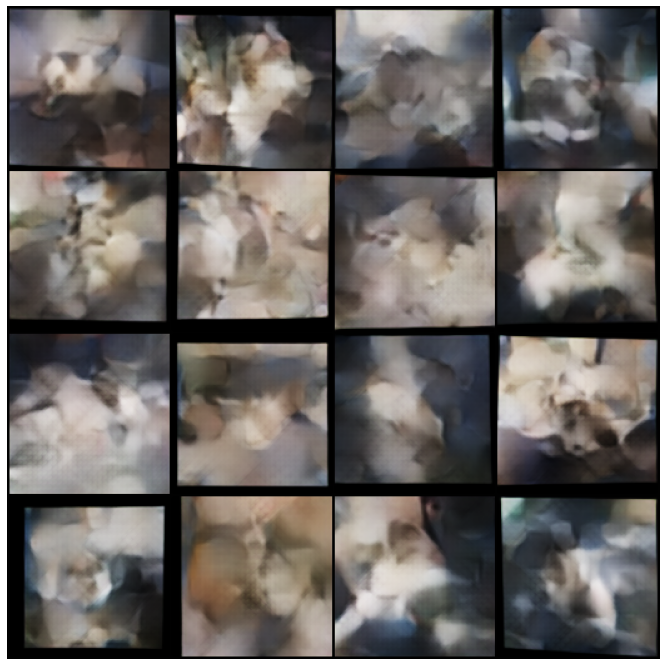

In [144]:
samples = model.sample(64)
visualize_batch(samples[:16])

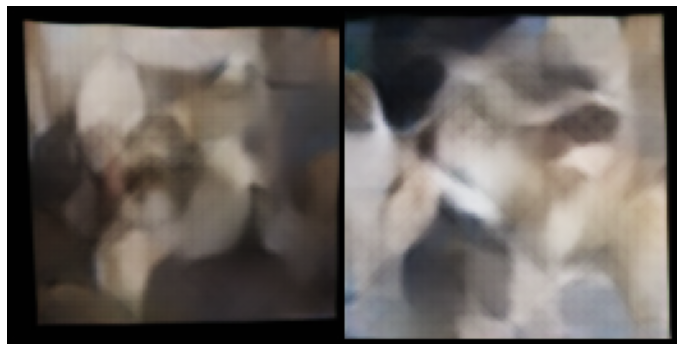

In [139]:
z = torch.normal(0 * torch.ones(2,400), 1*torch.ones(2,400)).to('cuda')
samples = model.decoder(z)
visualize_batch(samples)

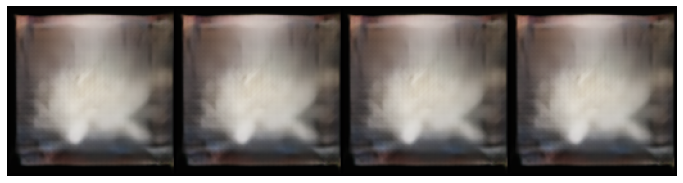

In [108]:
z = torch.ones(4, 400).to('cuda')
samples = model.decoder(z)
visualize_batch(samples)